In [109]:
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt
import os

# Adjust the path as needed
data_path = '../../data/nifty/test/featured.csv'
df = pd.read_csv(data_path)

# Ensure date is datetime and sort
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

In [ ]:
# SIMPLE PER-BAR TREND per spec: 
# HH+close_up => Uptrend, LL+close_down => Downtrend, else Sideways

print("=== SIMPLE PER-BAR TREND (spec) ===\n")

# Validate inputs
for col in ['high', 'low', 'close']:
    if col not in df.columns:
        raise ValueError(f"Missing required column: {col}")

prev_high = df['high'].shift(1)
prev_low = df['low'].shift(1)
prev_close = df['close'].shift(1)

higher_high = df['high'] > prev_high
lower_low = df['low'] < prev_low
close_up = df['close'] > prev_close
close_down = df['close'] < prev_close

# Core rules
is_up = higher_high & close_up
is_down = lower_low & close_down

# Inside-bar helper: today's range within yesterday's range
inside_bar = (df['high'] <= prev_high) & (df['low'] >= prev_low)

trend_spec = pd.Series('Sideways', index=df.index)
trend_spec[is_up] = 'Uptrend'
trend_spec[is_down] = 'Downtrend'
# Remaining are Sideways by default (including inside bars)

# Attach raw and forward-filled
df['dow_trend_spec_raw'] = trend_spec

df['dow_trend_spec'] = trend_spec.replace('Sideways', np.nan).ffill().fillna('Sideways')

# Quick check around early July (tz-safe)
date_series = df['date']
if getattr(date_series.dt, 'tz', None) is not None:
    date_cmp = date_series.dt.tz_localize(None)
else:
    date_cmp = date_series
mask = (date_cmp >= pd.Timestamp('2025-07-01')) & (date_cmp <= pd.Timestamp('2025-07-10'))
print(df.loc[mask, ['date','high','low','close','dow_trend_spec_raw','dow_trend_spec']].to_string(index=False))


=== SIMPLE PER-BAR TREND (spec) ===

                     date     high      low    close dow_trend_spec_raw dow_trend_spec
2025-07-01 00:00:00+05:30 25593.40 25501.80 25541.80           Sideways       Sideways
2025-07-02 00:00:00+05:30 25608.10 25378.75 25453.40          Downtrend      Downtrend
2025-07-03 00:00:00+05:30 25587.50 25384.35 25405.30           Sideways      Downtrend
2025-07-04 00:00:00+05:30 25470.25 25331.65 25461.00           Sideways      Downtrend
2025-07-07 00:00:00+05:30 25489.80 25407.25 25461.30            Uptrend        Uptrend
2025-07-08 00:00:00+05:30 25548.05 25424.15 25522.50            Uptrend        Uptrend
2025-07-09 00:00:00+05:30 25548.70 25424.35 25476.10           Sideways        Uptrend
2025-07-10 00:00:00+05:30 25524.05 25340.45 25355.25          Downtrend      Downtrend


In [ ]:
# BUILD AND SAVE df_dow_theory_trend
print("\n=== BUILDING df_dow_theory_trend AND SAVING CSV ===\n")

# Select available columns, prioritizing simple per-bar trend
candidate_cols = ['date','open','high','low','close','volume',
                  'dow_trend_spec_raw','dow_trend_spec',
                  'dow_trend_kbars_raw','dow_trend_kbars']
cols_present = [c for c in candidate_cols if c in df.columns]

df_dow_theory_trend = df[cols_present].copy()

# Normalize date to tz-naive ISO for CSV
if 'date' in df_dow_theory_trend.columns:
    if getattr(df_dow_theory_trend['date'].dt, 'tz', None) is not None:
        df_dow_theory_trend['date'] = df_dow_theory_trend['date'].dt.tz_localize(None)
    df_dow_theory_trend['date'] = df_dow_theory_trend['date'].dt.strftime('%Y-%m-%d')

# Default to 'dow_trend_spec' as the main trend if present
if 'dow_trend_spec' not in df_dow_theory_trend.columns and 'dow_trend_kbars' in df_dow_theory_trend.columns:
    df_dow_theory_trend['dow_trend_spec'] = df_dow_theory_trend['dow_trend_kbars']

# Save
candidate_cols_to_save = ['date','open','high','low','close','volume','dow_trend_spec']
output_path = '../../data/nifty/test/dow_theory_trend.csv'
df_dow_theory_trend_to_save = df_dow_theory_trend[candidate_cols_to_save].copy()

df_dow_theory_trend_to_save.to_csv(output_path, index=False)
print(f"Saved: {output_path}")

# Show tail for verification
print(df_dow_theory_trend_to_save.tail().to_string(index=False))


=== BUILDING df_dow_theory_trend AND SAVING CSV ===

Saved: ../../data/nifty/test/dow_theory_trend.csv
      date     open     high      low    close  volume dow_trend_spec_raw dow_trend_spec
2025-09-26 24818.55 24868.60 24629.45 24654.70       0          Downtrend      Downtrend
2025-09-29 24728.55 24791.30 24606.20 24634.90       0          Downtrend      Downtrend
2025-09-30 24691.95 24731.80 24587.70 24611.10       0          Downtrend      Downtrend
2025-10-01 24620.55 24867.95 24605.95 24836.30       0            Uptrend        Uptrend
2025-10-03 24759.55 24904.80 24747.55 24894.25       0            Uptrend        Uptrend



=== DOTTED BASELINE + COLORED SEGMENTS ===



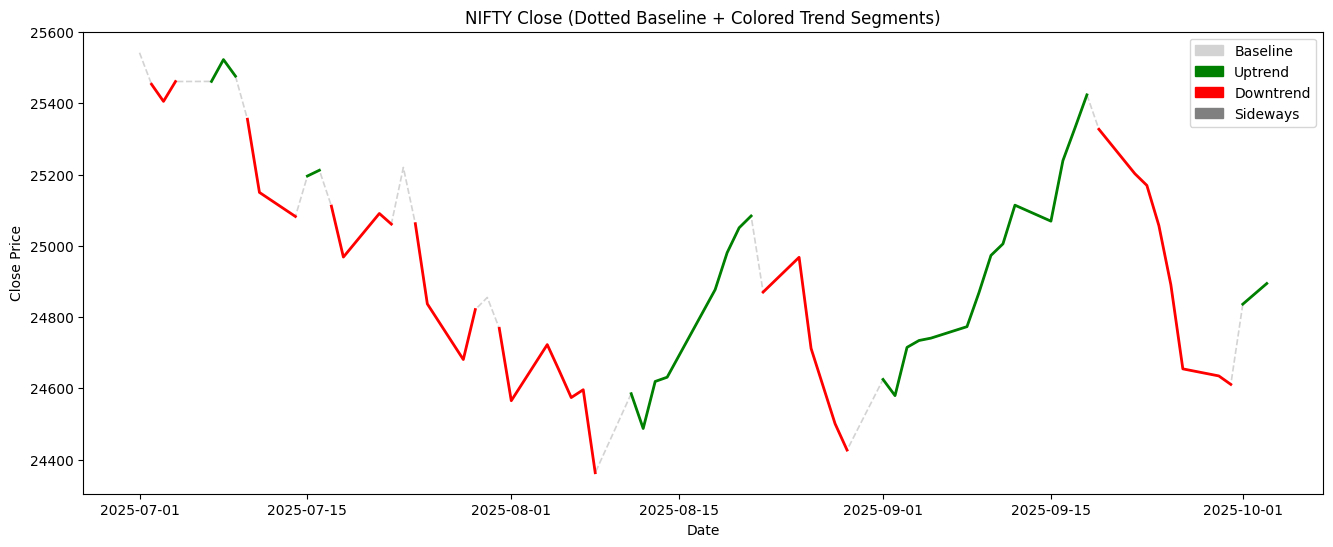

In [112]:
# DOTTED BASELINE + COLORED SEGMENTS (bridges gaps)
print("\n=== DOTTED BASELINE + COLORED SEGMENTS ===\n")

trend_col = 'dow_trend_spec'
if trend_col not in df.columns:
    raise ValueError(f"Missing trend column: {trend_col}")

run_id = (df[trend_col] != df[trend_col].shift(1)).cumsum()
trend_colors = {'Uptrend': 'green', 'Downtrend': 'red', 'Sideways': 'gray'}

plt.figure(figsize=(16,6))
# 1) Draw full series as dotted gray baseline
plt.plot(df['date'], df['close'], color='lightgray', linewidth=1.2, linestyle='--', label='Baseline')

# 2) Overlay colored contiguous segments
for rid, seg in df.groupby(run_id):
    t = seg[trend_col].iloc[0]
    color = trend_colors.get(t, 'black')
    plt.plot(seg['date'], seg['close'], color=color, linewidth=2)

plt.title('NIFTY Close (Dotted Baseline + Colored Trend Segments)')
plt.xlabel('Date')
plt.ylabel('Close Price')
import matplotlib.patches as mpatches
handles = [mpatches.Patch(color=c, label=k) for k,c in trend_colors.items()]
handles.insert(0, mpatches.Patch(color='lightgray', label='Baseline'))
plt.legend(handles=handles)
plt.show()
